In [26]:
def phot_filter(fil_name):
    import numpy as np
    from astropy.io import ascii
    from pprint import pprint
    filename = '/Users/yaolun/programs/fsps/data/allfilters.dat'
    foo = open(filename, 'r')
    index = []
    filter_name = []
    for i, line in enumerate(foo):
        if line[0] == '#':
            index.append(i)
            filter_name.append(line.split('#')[1].lstrip().rstrip())
    index = np.array(index)
    filter_name = np.array(filter_name)

    ind, =np.where(filter_name == fil_name)

    while len(ind) == 0:
        if fil_name != 'ls':
            print 'requested filter not found in database!'
        fil_name = raw_input('Please enter the filter name (or ls for listing the filters in database): ')
        if fil_name == 'ls':
            pprint(filter_name)
            # fil_name = raw_input('Please enter the filter name (or ls for listing the filters in database): ')
        ind, =np.where(filter_name == fil_name)
    if fil_name != filter_name[-1]:
        phot_filter = ascii.read(filename, data_start=index[ind]-ind, data_end=index[ind+1]-ind-1, names=['wave','transmission'],header_start=None)
    else:
        phot_filter = ascii.read(filename, data_start=index[ind]-ind, names=['wave','transmission'],header_start=None)

    return phot_filter, filter_name

In [17]:
def herschel_spec_phot(wl, flux, pacs=True, spire=False, filter_func=False):
    import numpy as np
    from scipy.interpolate import interp1d
    from phot_filter import phot_filter
    phot_wl = []
    if pacs == True:
        phot_wl.extend([70,100,160])
    if spire == True:
        phot_wl.extend([250,350,500])
    phot_wl = np.array(phot_wl)
    phot_flux = np.empty_like(phot_wl)
    for i in range(len(phot_wl)):
        if filter_func == False:
            res = 3     # temp. resolution to mimic the photometry filters
            ind = np.where((wl < phot_wl[i]*(1+1./res)) & (wl > phot_wl[i]*(1-1./res)))
            if len(ind[0]) != 0:
                phot_flux[i] = np.nanmean(flux[ind])
        else:
            # apply the filter function
            # decide the filter name
            if phot_wl[i] == 70:
                fil_name = 'Herschel PACS 70um'
            elif phot_wl[i] == 100:
                fil_name = 'Herschel PACS 100um'
            elif phot_wl[i] == 160:
                fil_name = 'Herschel PACS 160um'
            elif phot_wl[i] == 250:
                fil_name = 'Herschel SPIRE 250um'
            elif phot_wl[i] == 350:
                fil_name = 'Herschel SPIRE 350um'
            elif phot_wl[i] == 500:
                fil_name = 'Herschel SPIRE 500um'

            filter_func = phot_filter(fil_name)

            # trim the filter function
            if phot_wl[i] in [70,100,160]:
                filter_func = filter_func[(filter_func['wave']/1e4 >= max(54.8,min(wl)))*\
                                            ((filter_func['wave']/1e4 <= 95.05)+(filter_func['wave']/1e4 >=103))*\
                                          ((filter_func['wave']/1e4 <= 190.31)+(filter_func['wave']/1e4 >= 195))]
            elif phot_wl[i] in [250,350,500]:
                filter_func = filter_func[(filter_func['wave']/1e4 >= 195)]

            f = interp1d(wl, flux)

            phot_flux[i] = np.trapz(filter_func['wave']/1e4, f(filter_func['wave']/1e4)*filter_func['transmission'])/np.trapz(filter_func['wave']/1e4, filter_func['transmission'])

    return np.array(phot_wl), np.array(phot_flux)

###Testing the photometry filter convolution

[ 70 100 160] [139 267 303]


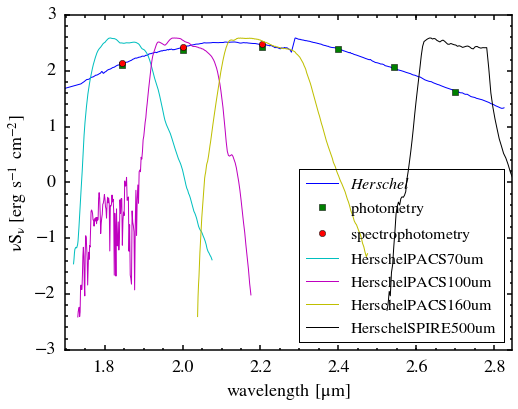

In [25]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import sys
sys.path.append('/Users/yaolun/programs/misc/hyperion')
from get_bhr71_obs import get_bhr71_obs

bhr71 = get_bhr71_obs('/Users/yaolun/bhr71/obs_for_radmc/')

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(np.log10(bhr71['spec'][0]), np.log10(bhr71['spec'][1]), label=r'$\it{Herschel}$')
ax.plot(np.log10(bhr71['phot'][0]), np.log10(bhr71['phot'][1]), 's', label=r'$\rm{photometry}$')
ax.set_xlim([np.log10(50),np.log10(700)])

fil_name = 'Herschel PACS 70um'
filter_func = phot_filter(fil_name)
phot_wl, phot_flux = herschel_spec_phot(bhr71['spec'][0], bhr71['spec'][1], filter_func=True)
print phot_wl,phot_flux
ax.plot(np.log10(phot_wl), np.log10(phot_flux), 'o', label=r'$\rm{spectrophotometry}$')

fil_name = ['Herschel PACS 70um', 'Herschel PACS 100um', 'Herschel PACS 160um', 'Herschel SPIRE 500um']

for ifil in fil_name:
    filter_func = phot_filter(ifil)
    ax.plot(np.log10(filter_func['wave']/1e4), np.log10(filter_func['transmission']*max(bhr71['spec'][1])), label=r'$\rm{'+ifil+'}$')

ax.legend(loc='best', numpoints=1, fontsize=16)
ax.set_xlabel(r'$\rm{wavelength\,[\mu m]}$', fontsize=18)
ax.set_ylabel(r'$\rm{\nu S_{\nu}\,[erg\,s^{-1}\,cm^{-2}]}$', fontsize=18)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)

fig.savefig('/Users/yaolun/test/spectrophot_bhr71.pdf', format='pdf', dpi=300, bbox_inches='tight')

##Plot filter functions

IndexError: index 122 is out of bounds for axis 1 with size 122

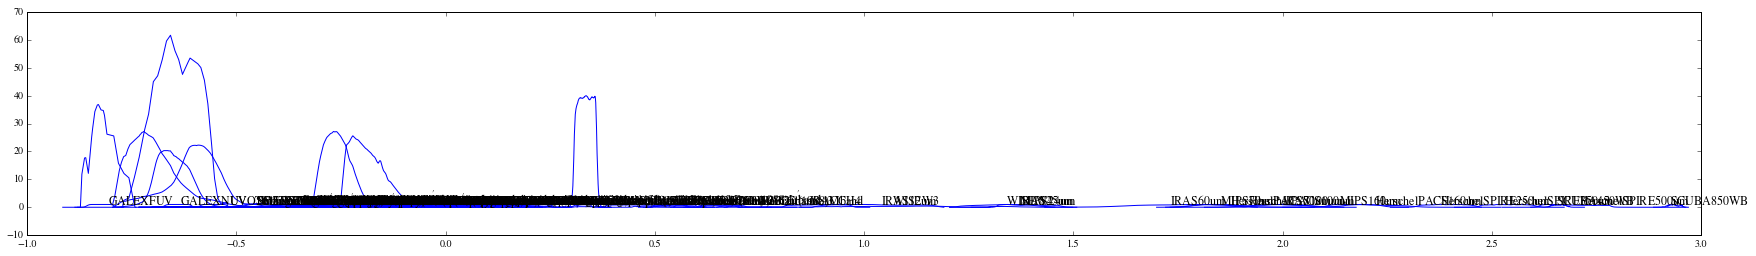

In [28]:
# get all filter name
phot_fil_dum, filter_name = phot_filter('Herschel PACS 70um')
# fil_name = ['Herschel PACS 70um', 'Herschel PACS 100um', 'Herschel PACS 160um', 'Herschel SPIRE 500um']

fig = plt.figure(figsize=(30,4))
ax = fig.add_subplot(111)

i = -1
for ifil in filter_name:
    filter_func, dum = phot_filter(ifil)
    ax.plot(np.log10(filter_func['wave']/1e4), filter_func['transmission'], color='Blue')
    ax.text(np.mean(np.log10(filter_func['wave']/1e4)), 0.9+0.1*i, r'$\rm{'+ifil+'}$', fontsize=12)
    i = i*(-1)

ax.legend(loc='best', numpoints=1, fontsize=16)
ax.set_xlabel(r'$\rm{wavelength\,[\mu m]}$', fontsize=18)
ax.set_ylabel(r'$\rm{\nu S_{\nu}\,[erg\,s^{-1}\,cm^{-2}]}$', fontsize=18)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)

fig.savefig('/Users/yaolun/test/phot_filter.pdf', format='pdf', dpi=300, bbox_inches='tight')